In [1]:
import ase
import matplotlib.pyplot as plt
import numpy as np

import abtem

# Scan & Detect 

### Setup

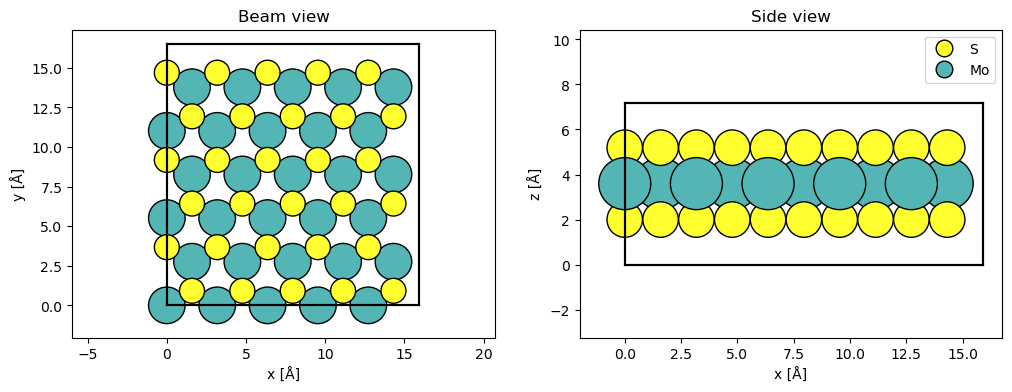

In [2]:
#create MoS2 Structure
atoms = ase.build.mx2(vacuum=2)
atoms = abtem.orthogonalize_cell(atoms)
atoms = atoms * (5, 3, 1)
#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, title="Beam view", ax=ax1)
abtem.show_atoms(atoms, legend=True, plane="xz", title="Side view", ax=ax2);

In [4]:
#create Potential (with sampling of 0.05 A°) & Probe (80 keV)
potential = abtem.Potential(atoms, sampling=0.05)
probe = abtem.Probe(energy=80e3, semiangle_cutoff=20)
probe.grid.match(potential)

### Scanning 

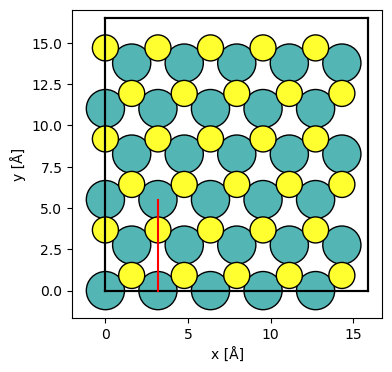

In [5]:
#3 Types: Grid Scan, line scan, costum scan
#below creation of line scan, see plot. Endpoint=False because covered region is periodic -> start & endpoint are equivalent
#anders: Endpoint=True würde heißen: letzter Punkt noch inkludiert, nachdem Periodisch, ist das schon wieder start von nächstem
line_scan = abtem.LineScan(start=(potential.extent[0] / 5.0, 0.0), end=(potential.extent[0] / 5.0, potential.extent[1] / 3.0), gpts=50, endpoint=False,)
fig, ax = abtem.show_atoms(atoms, figsize=(4,4))
line_scan.add_to_axes(ax, color="r")

In [6]:
#potential.extent
potential.shape

(8, 318, 331)

In [7]:
#multislicing with providing potential& scan -> creation of exit wave along every point of scan line -> we get 50 wave functions
exit_waves_line = probe.multislice(potential=potential, scan=line_scan)
exit_waves_line.shape

(50, 318, 331)

### Detectors

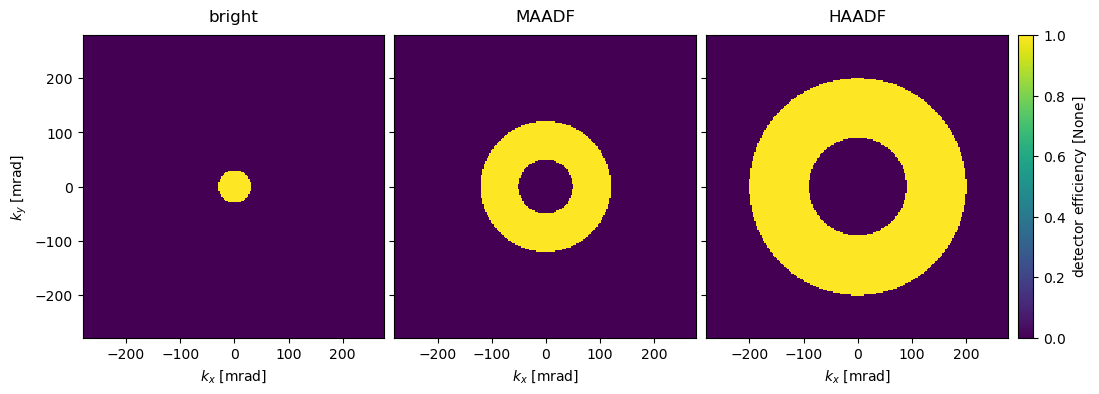

In [8]:
#creating Annular Detectors: Bright Field, Medium Angle Annular Dark Field, High Angle Annular Dark Field; degrees in mrad
bf = abtem.AnnularDetector(inner=0, outer=30)
maadf = abtem.AnnularDetector(inner=50, outer=120)
haadf = abtem.AnnularDetector(inner=90, outer=200)

#plot detector regions
bright_region = bf.get_detector_region(exit_waves_line)
maadf_region = maadf.get_detector_region(exit_waves_line)
haadf_region = haadf.get_detector_region(exit_waves_line)
stacked_regions = abtem.stack((bright_region, maadf_region, haadf_region), ("bright", "MAADF", "HAADF"))

visualization = stacked_regions.show(explode=True, cbar=True, common_color_scale=True, units="mrad",  figsize=(12, 4))

In [10]:
#application of detector
haadf.detect(exit_waves_line)

In [11]:
#combination of scan and detect
all_detectors = [bf, maadf, haadf]

measurements = probe.scan(potential, detectors=all_detectors, scan=line_scan).compute()


[########################################] | 100% Completed | 12.43 ss


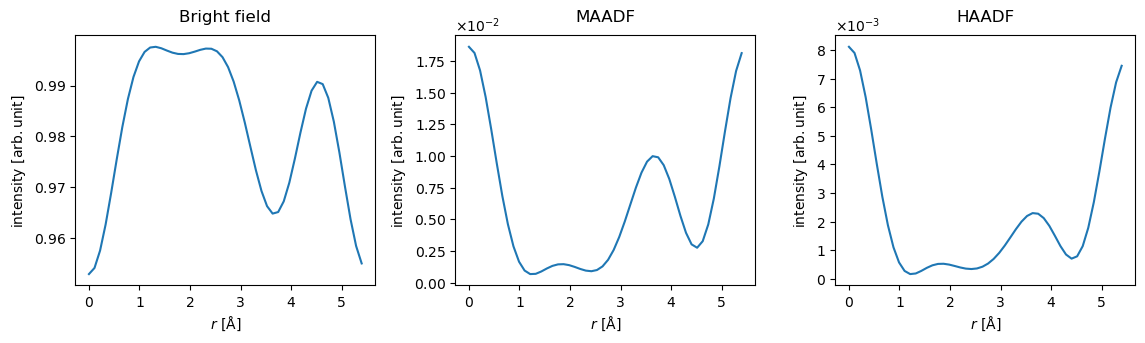

In [12]:
#show
measurements = abtem.stack(measurements, ("Bright field", "MAADF", "HAADF"))
visualization = measurements.show(explode=True, common_scale=False, figsize=(12, 3))

### STEM Simulations

Nyquist sampling = 0.522 Å/pixel


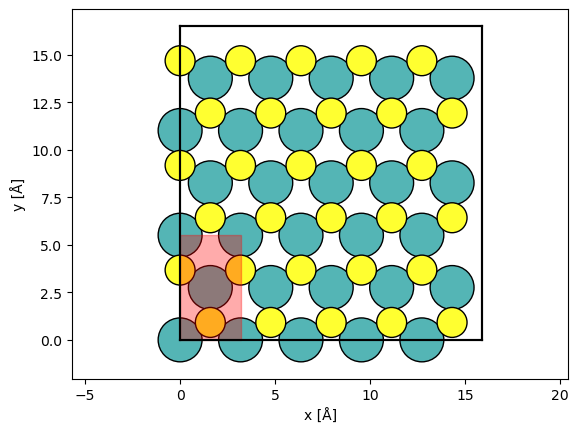

In [15]:
#"The probe step size (or sampling) is set to the Nyquist frequency of the probe contrast transfer function." (später nachlesen)
sampling = probe.aperture.nyquist_sampling
print(f"Nyquist sampling = {sampling:.3f} Å/pixel")

#plot
grid_scan = abtem.GridScan(start=[0, 0], end=[2 / 5, 1], sampling=sampling, fractional=True, potential=potential,) 
#fractional=True -> heißt: nur Teil von Potential abgedeckt: "If True, use fractional coordinates with respect to the given potential for start and end."
fig, ax = abtem.show_atoms(atoms)
grid_scan.add_to_plot(ax)

In [16]:
#apply scan & detect
measurements = probe.scan(potential, scan=grid_scan, detectors=all_detectors)
measurements = abtem.stack(measurements, ("BF", "MAADF", "HAADF"))
measurements.to_zarr("./data/mos2_stem_measurements.zarr");

[########################################] | 100% Completed | 14.60 ss


In [19]:
imported_measurements = abtem.from_zarr("./data/mos2_stem_measurements.zarr").compute()

[########################################] | 100% Completed | 106.48 ms


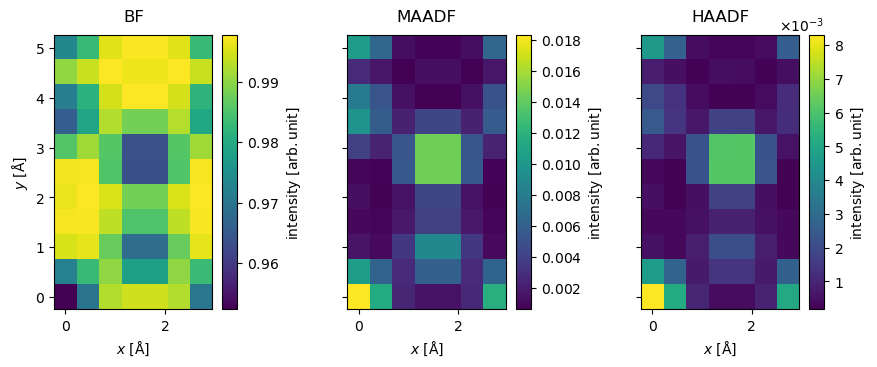

In [20]:
imported_measurements.show(explode=True, cbar=True, figsize=(10, 5));

### Post-Processing

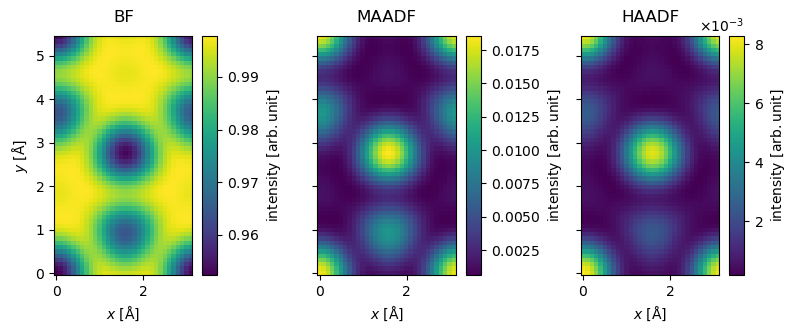

In [26]:
#apply interpolation algorithm (default:Fourier-Space padding)
interpolated_measurements = imported_measurements.interpolate(sampling=0.1)
vis = interpolated_measurements.show(explode=True, common_color_scale=False, cbar=True, figsize=(9,4))
vis.axes.set_sizes(cbar_spacing=1)

### Blurring & Noise

(3, 32, 56)

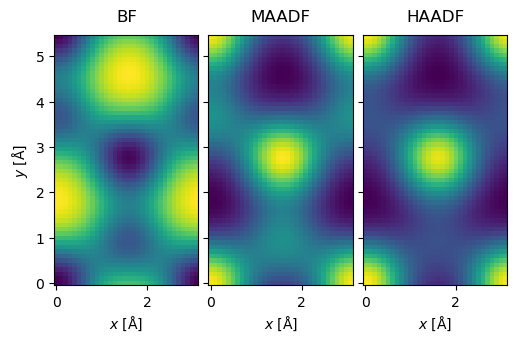

In [34]:
#we get blurring from a gaussian-shaped source (+ additional through vibrations, instabilities..)
#add gaussian blur with standard dev of 0.5 °A

blurred_measurements = interpolated_measurements.gaussian_filter(0.5)
vis = blurred_measurements.show(explode=True, figsize=(8,3))
blurred_measurements.shape

In [37]:
#in the (realistic) case of a finite electron dose(#electonen pro Fläche), we will see noise due to law of large numbers:"shot noise"/"poisson noise"
#verleichbar mit Schwankungen einer Wahrscheinlichkeitsverteilung bei kleineren Versuchsanzahlen -> 
tiled_measurements = blurred_measurements.tile((7,4))#tile = ziegel, platte? wird jedenfalls erweitert, vgl. shapes
tiled_measurements.shape

(3, 224, 224)

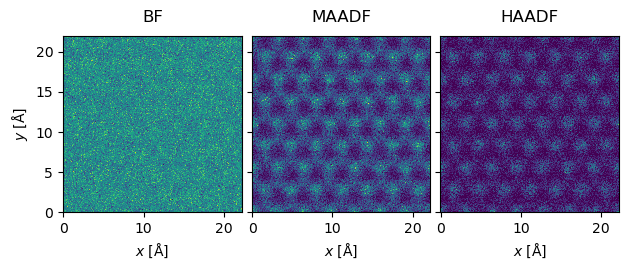

In [38]:
#noise anwenden mit 10^5 Elektronen/°A^2
noisy_measurement = tiled_measurements.poisson_noise(dose_per_area=1e5, seed=100)
noisy_measurement.show(explode=True)

### Detecors

Es gibt unterschiedlichste Detektoren: AnnularDetector, FlexibleAnnularDetector, SegmentedDetector, PixelatedDetector, WavesDetector \
für uns relevant: AnnularDetector (vgl oben) evtl. WavesDetector (internal use -> try (not in the documentation))

In [43]:
#FLEXIBLE ANNULAR DETECTOR = default detector in abTEM; speichert Intensitäten der Diffraction Patterns in radialen bins ->
#kann dadurch erst im Nachhinein angeben, von wo bis wo mein jeweiliger Detektor laufen soll (und trzd. weniger Speicher als 4D-Scan)

flex_dect = abtem.FlexibleAnnularDetector(step_size=2) #stepsize in mrad
flex_measure = probe.scan(potential, scan=grid_scan, detectors=flex_dect).compute()

[########################################] | 100% Completed | 15.00 ss


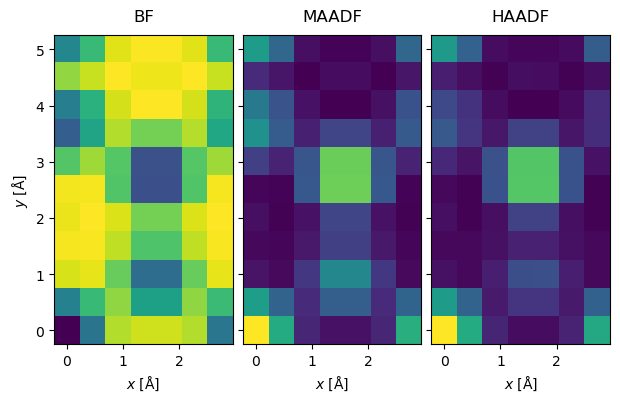

In [46]:
#now reproduce radial detectors from above
stacked = abtem.stack([flex_measure.integrate_radial(0,30), flex_measure.integrate_radial(50,120),flex_measure.integrate_radial(90,200)],("BF", "MAADF","HAADF"))
stacked.show(explode=True)